# W207 Final Project: Zillow Prize: Zillow’s Home Value Prediction

* Gray Selby
* Amir Moazami
* Soroush Yazdani

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate divided by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We have been provided with a comprehensive dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for the year 2016.

The training data consists of all property transactions that occurred before October 15, 2016, as well as some transactions that took place after that date.

The test data available in the public leaderboard includes the remaining transactions that occurred between October 15 and December 31, 2016.

The rest of the test data, which is used to calculate the private leaderboard scores, encompasses all the properties sold between October 15, 2017, and December 15, 2017. This particular period is referred to as the "sales tracking period," during which no submissions will be accepted.

Our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

When a property is sold multiple times within a 31-day period, we will consider the first reasonable value as the ground truth. The notion of "reasonable" entails selecting the transaction with a value that appears more accurate if the data seems questionable.

To begin, we will import the necessary libraries and obtain the dataset from Kaggle.com. Subsequently, we will conduct exploratory data analysis (EDA) to enhance the cleanliness of the dataset. Finally, we will employ some machine learning techniques to establish the best model.









In [1]:
# Import the libraries we'll use below.
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

In [2]:
# set numpy random dseed
np.random.seed(42)
# instantiate numpy random number generator
rng = np.random.default_rng(42)

In [3]:
# Import our utilities.py file
import importlib
import utilities
importlib.reload(utilities)
from utilities import *

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')


In [5]:
# Instantiate
ZD = ZillowData(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset")

In [6]:
# Instantiate (Amir)
#ZD = ZillowData("/pa/home/amir.moazami/Projects/207/final_proj/Zillow_Dataset")

# Load the Data

Check the method get_data() in utilities.py for the implementation.

In [7]:
ZD.get_data()
ZD.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid                    1272 non-null    float64
 12  finishedfloor1squarefeet      12893 non-null

### Check for duplicate entries

In [8]:
ZD.check_for_duplicates()

Number of duplicates IDs: 0 / 167888


# Train, Validation, Test Split

We have ensured that each row is unique so we will randomly select 70% of the rows for the train set and split the remaining rows between validation and test sets.

In [9]:
ZD.train_val_test_split(train_prob=0.7)

Train set ratio: 0.70
Validation set ratio: 0.15
Test set ratio: 0.15


# Baseline Targets

In [10]:
# Mean absolute error
ZD.train.logerror.mad()

0.06971411951878244

In [11]:
# Mean squared error
ZD.train.logerror.std()

0.16535616094727335

## The regression prediction targets

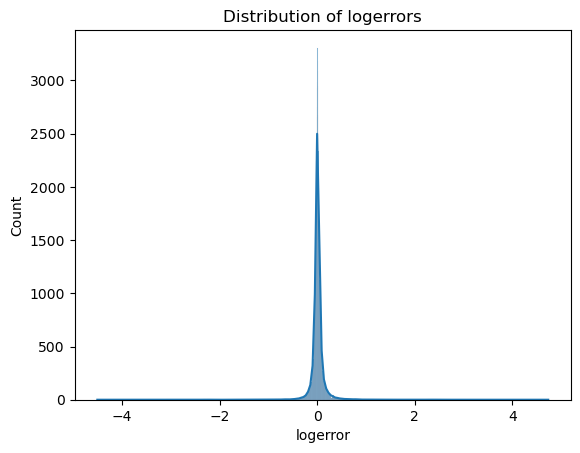

In [12]:
ZD.plot_logerr_hist(df=ZD.train)

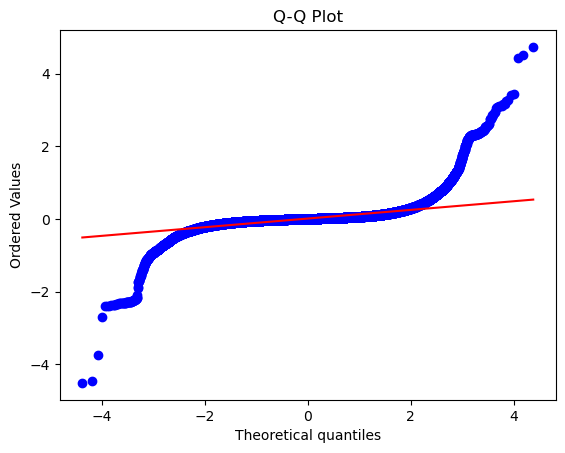

In [13]:
ZD.plot_logerr_QQ(df=ZD.train)

Given the presence of outliers, let us remove extreme examples more than 3 standard deviations from the mean.

In [14]:
def remove_outliers(data_df, n_stds=3):
    len_df = data_df.shape[0]
    high_thresh = data_df.logerror.mean() + n_stds * data_df.logerror.std()
    low_thresh = data_df.logerror.mean() - n_stds * data_df.logerror.std()
    trimmed_df = data_df[data_df.logerror < high_thresh]
    trimmed_df = trimmed_df[data_df.logerror > low_thresh]

    len_trimmed = trimmed_df.shape[0]
    print(f'{len_df - len_trimmed} of {len_df} outliers removed.')

    return trimmed_df

In [15]:
trimmed_train = remove_outliers(ZD.train, n_stds=3)

1746 of 117521 outliers removed.


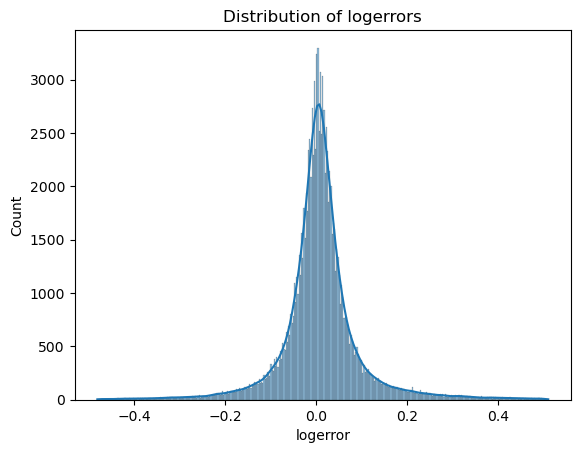

In [16]:
ZD.plot_logerr_hist(df=trimmed_train)

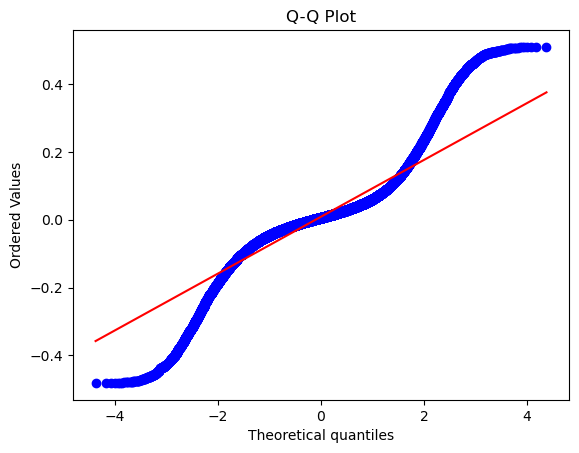

In [17]:
ZD.plot_logerr_QQ(df=trimmed_train)

Now we update the train set after the outliers were removed. We do not touch the validation or test sets as that would be improper. The point of removing extreme outliers from the train set is to allow our models to focus on learning the general trend instead of trying to accomodate outlier cases.

In [18]:
ZD.train = trimmed_train

Next form the datasets by separating the X data from the Y targets.

In [19]:
ZD.form_datasets()

In [20]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 59), Y shapes: (115775, 1)
Validation X shapes: (25184, 59),  Y shapes: (25184, 1)
Test X shapes:       (25183, 59),  Y shapes: (25183, 1)


## Missing data

In [21]:
train_na_ratio_df = ZillowData.get_missing_ratio_df(ZD.train_x)

Unfortunately nearly half of the data is missing.

In [22]:
print(f'Average percent of missing data per column: {train_na_ratio_df.NAN_ratio.mean()*100:.1f}%')

Average percent of missing data per column: 47.6%


Each column's missing data ratio is shown below.

In [23]:
train_na_ratio_df

,NAN_ratio
buildingclasstypeid,0.999845
finishedsquarefeet13,0.999594
storytypeid,0.999447
basementsqft,0.999447
yardbuildingsqft26,0.998955
fireplaceflag,0.997659
architecturalstyletypeid,0.997132
typeconstructiontypeid,0.996804
finishedsquarefeet6,0.995483
decktypeid,0.992477


## Handling of missing data


In [24]:
ZD.clean_all_data()

In [25]:
ZD.convert_column_type(col_type=np.float32)

In [26]:
print(f'Train X shapes:      {ZD.train_x.shape}, Y shapes: {ZD.train_y.shape}')
print(f'Validation X shapes: {ZD.val_x.shape},  Y shapes: {ZD.val_y.shape}')
print(f'Test X shapes:       {ZD.test_x.shape},  Y shapes: {ZD.test_y.shape}')

Train X shapes:      (115775, 37), Y shapes: (115775, 1)
Validation X shapes: (25184, 37),  Y shapes: (25184, 1)
Test X shapes:       (25183, 37),  Y shapes: (25183, 1)


In [27]:
ZD.train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115775 entries, 81426 to 13739
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   airconditioningtypeid         115775 non-null  float32
 1   bathroomcnt                   115775 non-null  float32
 2   bedroomcnt                    115775 non-null  float32
 3   buildingqualitytypeid         115775 non-null  float32
 4   decktypeid                    115775 non-null  float32
 5   calculatedfinishedsquarefeet  115775 non-null  float32
 6   finishedsquarefeet12          115775 non-null  float32
 7   fips                          115775 non-null  float32
 8   fireplacecnt                  115775 non-null  float32
 9   garagecarcnt                  115775 non-null  float32
 10  garagetotalsqft               115775 non-null  float32
 11  hashottuborspa                115775 non-null  float32
 12  heatingorsystemtypeid         115775 non-

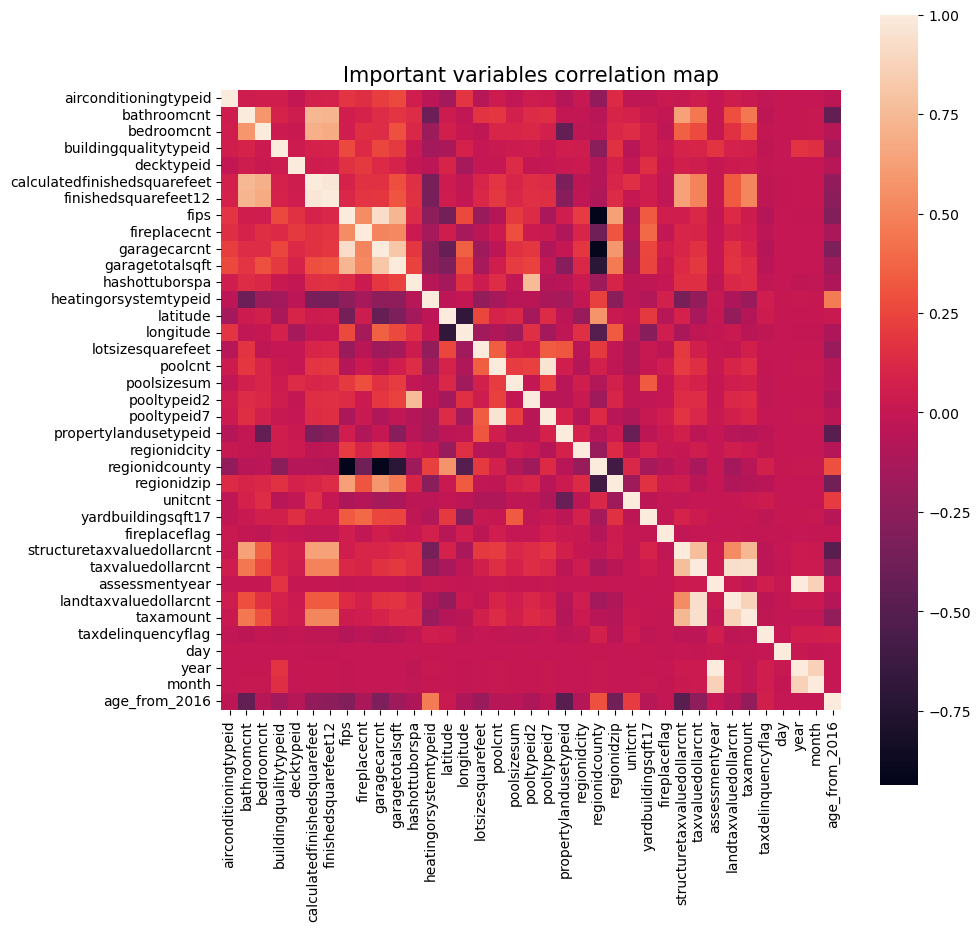

In [28]:
corrmat = ZD.train_x.corr(method='spearman')

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

From the correlation map, we can see the following highly correlated columns:
 - Group 1: `(one of these two should be dropped)`
    - calculatedfinishedsquarefeet
    - finishedsquarefeet12
 - Group 2: `(one of these two should be dropped)`
    - poolcnt
    - pooltypeid7
 - Group 3: `(between one and three of these can be dropped)`
    - structuretaxvaluedollarcnt
    - taxvaluedollarcnt
    - landtaxvaluedollarcnt
    - taxdeliquencyflag
 - Group 4: `(year and month could potentially be dropped)`
    - assessmentyear
    - year
    - month

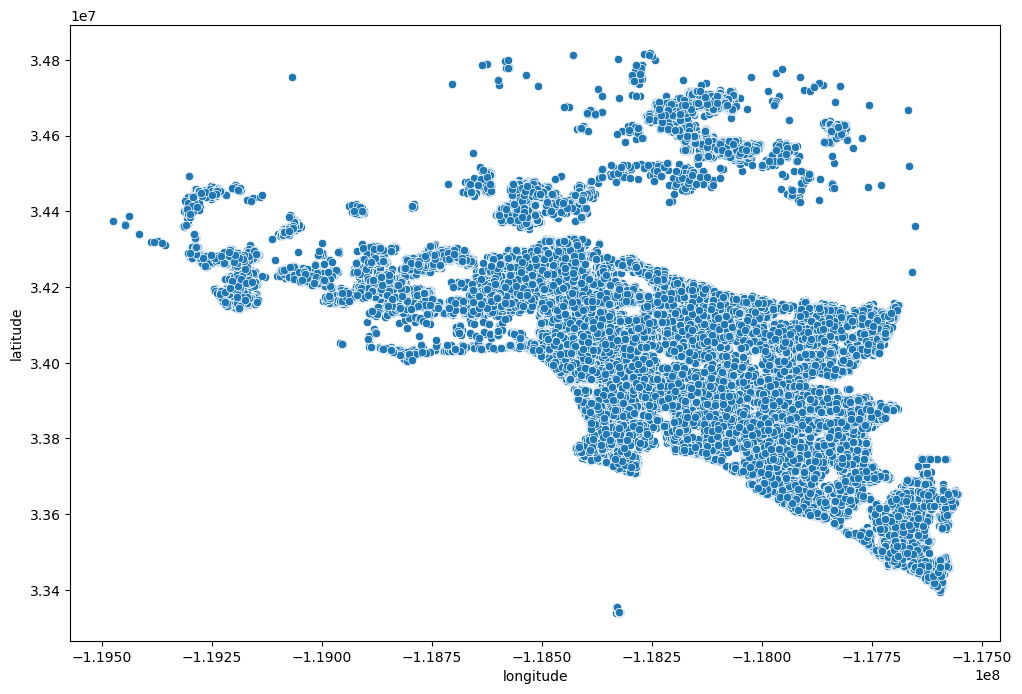

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',data=ZD.train_x)
plt.show()

That pretty much very similar to google map picture. For some resoan the satelite picture doesn't show up after saving it to the git hub.

![](https://drive.google.com/uc?export=view&id=1ffaNzw2p8MJWOg3lHRQ98reoL1AlB4Oe)

# Feature Selection

We used ExtraTreesRegressor library from Sklearn library here to find which features are the most important ones. Sklearn uses other libraries such as Random Forest, Gradient Boosting, AdaBoost regressor libraries to perform regression tasks. We will study those libraries in depth later.

Also, we are getting rid of the below features since they don't have good correlation with data:

- "hashottuborspa"
- "propertycountylandusecode"
- "propertyzoningdesc"
- "fireplaceflag"
- "taxdelinquencyflag"

In [30]:
ZD.train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115775 entries, 81426 to 13739
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   airconditioningtypeid         115775 non-null  float32
 1   bathroomcnt                   115775 non-null  float32
 2   bedroomcnt                    115775 non-null  float32
 3   buildingqualitytypeid         115775 non-null  float32
 4   decktypeid                    115775 non-null  float32
 5   calculatedfinishedsquarefeet  115775 non-null  float32
 6   finishedsquarefeet12          115775 non-null  float32
 7   fips                          115775 non-null  float32
 8   fireplacecnt                  115775 non-null  float32
 9   garagecarcnt                  115775 non-null  float32
 10  garagetotalsqft               115775 non-null  float32
 11  hashottuborspa                115775 non-null  float32
 12  heatingorsystemtypeid         115775 non-

In [31]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(ZD.train_x, ZD.train_y)

ExtraTreesRegressor(max_depth=30, max_features=0.3, n_estimators=25, n_jobs=-1,
                    random_state=0)

In [32]:
## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

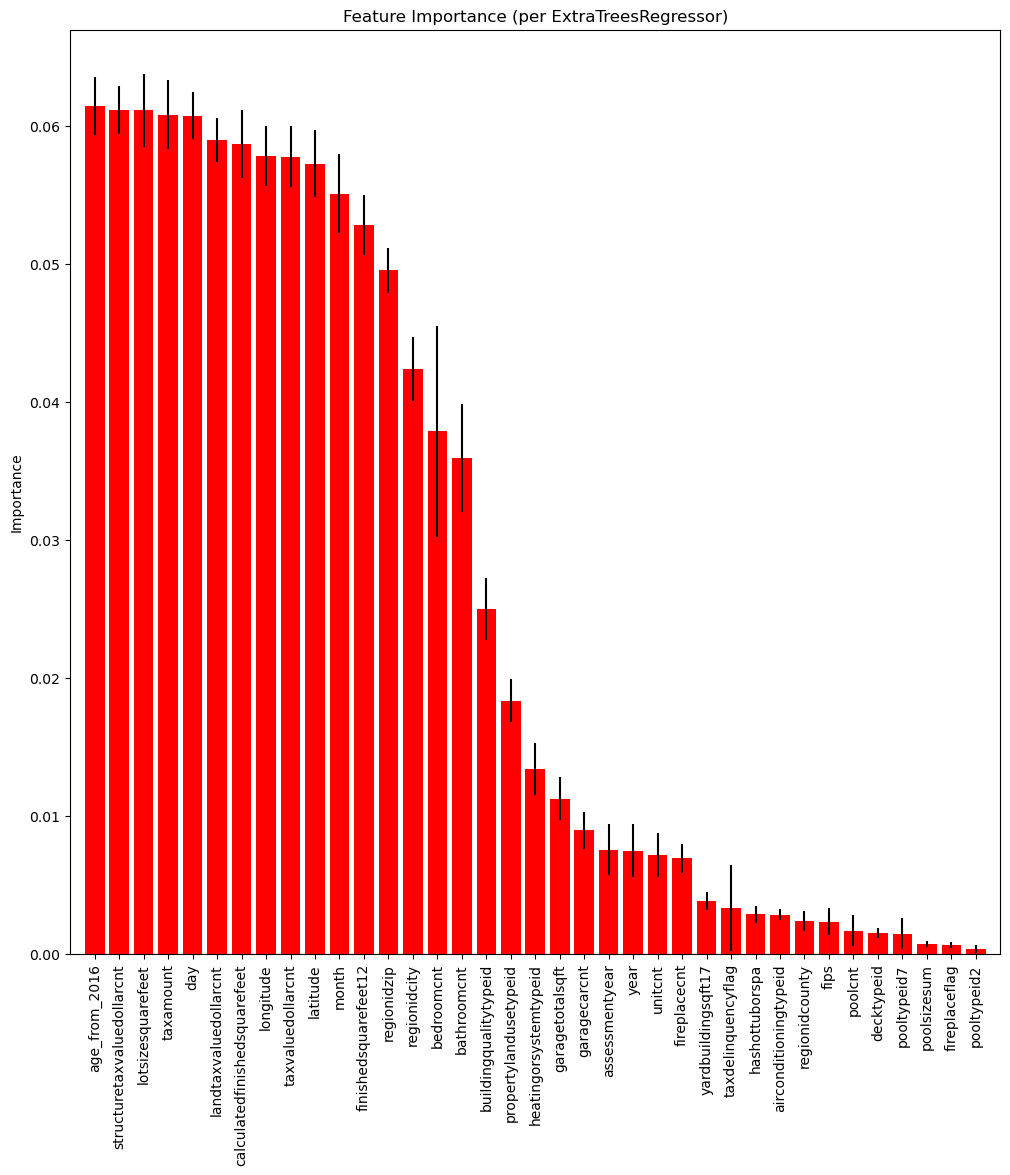

In [33]:
plt.figure(figsize=(12,12))
plt.title("Feature Importance (per ExtraTreesRegressor)")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), ZD.train_x.columns.values[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.ylabel('Importance')
plt.show()

In [34]:
# importing sklearn libraries
from sklearn.preprocessing import StandardScaler , RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split , cross_val_predict , RandomizedSearchCV
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [35]:
#minmaxscalar = MinMaxScaler()
standardscalar = StandardScaler()

In [36]:
ZD.train_x_normalized = standardscalar.fit_transform(ZD.train_x)
ZD.val_x_normalized = standardscalar.transform(ZD.val_x)
ZD.test_x_normalized = standardscalar.transform(ZD.test_x)

# ML Models

In the below ML models we use 'GridsearchCV' technique to find the best hyperparameters. GridSearchCV (Grid Search Cross-Validation) is a technique used to systematically search for the best combination of hyperparameters for a machine learning model. It's a common method for hyperparameter tuning, especially when we have a limited number of hyperparameters to tune and we want to explore all possible combinations of these hyperparameters. We used this for Lasso, Random Forest, XGBoost and KNN, Nueral Network models.

In below section, you will see the work for each ML model.

## Lasso

In [37]:
# from sklearn.linear_model import Lasso
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
# }

# # Create the Lasso model
# lasso_model = Lasso()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# # Fit the grid search to your data
# grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Use the best model for prediction
# y_pred = best_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [38]:
# plt.figure(figsize=(12,6))
# plt.scatter(ZD.val_y, y_pred)
# plt.xlabel('Validation set')
# plt.ylabel('Prediction set')
# plt.title('Prediction vs Validaion plot')

In [39]:
sample_sub = pd.read_csv(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset\sample_submission.csv")
sample_sub['parcelid'] = sample_sub['ParcelId']
#sample_sub = sample_sub.drop('ParcelId', axis=1)
sample_sub

,ParcelId,201610,201611,201612,201710,201711,201712,parcelid
0,10754147,0,0,0,0,0,0,10754147
1,10759547,0,0,0,0,0,0,10759547
2,10843547,0,0,0,0,0,0,10843547
3,10859147,0,0,0,0,0,0,10859147
4,10879947,0,0,0,0,0,0,10879947
...,...,...,...,...,...,...,...,...
2985212,168176230,0,0,0,0,0,0,168176230
2985213,14273630,0,0,0,0,0,0,14273630
2985214,168040630,0,0,0,0,0,0,168040630
2985215,168040830,0,0,0,0,0,0,168040830


In [40]:
housing_info_2016 = pd.read_csv(
            os.path.join(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset", "properties_2016.csv")
        )
housing_info_2016

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_test = pd.merge(sample_sub[['parcelid']], housing_info_2016, on='parcelid', how='left')

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# Create and fit the Random Forest regression model
xgb_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    subsample=1.0,
    random_state=42,
)
xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}

#y_pred_lst = []

submission = pd.DataFrame({'ParcelId': df_test['parcelid']})

for label, test_date in test_dates.items():
    print(f'Predicting for {label}')
    temp_df_test = pd.merge(sample_sub[['parcelid']], housing_info_2016, on='parcelid', how='left')
    
    temp_df_test['transactiondate'] = test_date
    
    temp_df_test_cleaned = ZD.clean_df(temp_df_test)
    
    print(temp_df_test_cleaned.year[0], temp_df_test_cleaned.month[0], temp_df_test_cleaned.age_from_2016[0])
    
    temp_df_test_cleaned_normed = standardscalar.fit_transform(temp_df_test_cleaned)
    
    # Make predictions on the test set
    y_pred = xgb_model.predict(temp_df_test_cleaned_normed)
    #y_pred_lst.append(y_pred)
    submission[label] = y_pred
    
submission

Predicting for 201610
2016 9 61.0
Predicting for 201611
2016 10 61.0
Predicting for 201612
2016 11 61.0
Predicting for 201710
2017 21 61.0
Predicting for 201711
2017 22 61.0
Predicting for 201712
2017 23 61.0


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907
1,10759547,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976
2,10843547,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346
3,10859147,0.006895,0.006895,0.006895,0.006895,0.006895,0.006895
4,10879947,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803
...,...,...,...,...,...,...,...
2985212,168176230,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985213,14273630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985214,168040630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985215,168040830,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715


In [43]:
pd.read_csv(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset\submission_individual_dates_001.csv")

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907,-0.019907
1,10759547,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976,-0.016976
2,10843547,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346,-0.007346
3,10859147,0.006895,0.006895,0.006895,0.006895,0.006895,0.006895
4,10879947,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803,-0.004803
...,...,...,...,...,...,...,...
2985212,168176230,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985213,14273630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985214,168040630,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715
2985215,168040830,0.009715,0.009715,0.009715,0.009715,0.009715,0.009715


In [44]:
save_path = r'C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset'
save_name = 'submission_individual_dates_002.csv'
submission.to_csv(os.path.join(save_path, save_name), index=False)

In [45]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import xgboost as xgb

# # Create and fit the Random Forest regression model
# xgb_model = xgb.XGBRegressor(
#     learning_rate=0.1,
#     max_depth=3,
#     n_estimators=200,
#     subsample=1.0,
#     random_state=42,
# )
# xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

# # Make predictions on the test set
# y_pred = xgb_model.predict(df_test_cleaned_normed)

In [81]:
sample_sub = pd.read_csv(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset\sample_submission.csv")
sample_sub['parcelid'] = sample_sub['ParcelId']
#sample_sub = sample_sub.drop('ParcelId', axis=1)
#sample_sub

In [82]:
housing_info_2016 = pd.read_csv(
            os.path.join(r"C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset", "properties_2016.csv")
        )
#housing_info_2016

In [83]:
df_test = pd.merge(sample_sub[['parcelid']], housing_info_2016, on='parcelid', how='left')

In [98]:
df_test.yearbuilt

0             NaN
1             NaN
2             NaN
3          1948.0
4          1947.0
            ...  
2985212       NaN
2985213       NaN
2985214       NaN
2985215       NaN
2985216       NaN
Name: yearbuilt, Length: 2985217, dtype: float64

In [84]:
df_test['transactiondate'] = pd.Timestamp('2016-12-01')
#df_test

In [97]:
df_test_cleaned = ZD.clean_df(df_test)

0          61.0
1          61.0
2          61.0
3          68.0
4          69.0
           ... 
2985212    61.0
2985213    61.0
2985214    61.0
2985215    61.0
2985216    61.0
Name: age_from_2016, Length: 2985217, dtype: float64

In [ ]:
df_test_cleaned.age_from_2016

In [89]:
print(df_test["transactiondate"])
datetime_obj = pd.to_datetime(df_test["transactiondate"]).dt

0         2016-12-01
1         2016-12-01
2         2016-12-01
3         2016-12-01
4         2016-12-01
             ...    
2985212   2016-12-01
2985213   2016-12-01
2985214   2016-12-01
2985215   2016-12-01
2985216   2016-12-01
Name: transactiondate, Length: 2985217, dtype: datetime64[ns]


In [90]:
print(f'day: {datetime_obj.day}')

day: 0          1
1          1
2          1
3          1
4          1
          ..
2985212    1
2985213    1
2985214    1
2985215    1
2985216    1
Name: transactiondate, Length: 2985217, dtype: int64


In [91]:
print(f'year: {(datetime_obj.year).astype("category")}')

year: 0          2016
1          2016
2          2016
3          2016
4          2016
           ... 
2985212    2016
2985213    2016
2985214    2016
2985215    2016
2985216    2016
Name: transactiondate, Length: 2985217, dtype: category
Categories (1, int64): [2016]


In [92]:
print(f'month: {((datetime_obj.year - 2016) * 12 + datetime_obj.month).astype("category")}')

month: 0          12
1          12
2          12
3          12
4          12
           ..
2985212    12
2985213    12
2985214    12
2985215    12
2985216    12
Name: transactiondate, Length: 2985217, dtype: category
Categories (1, int64): [12]


In [94]:
print(f'age from 2016: {2016.0 - df_test["yearbuilt"]}')

age from 2016: 0           NaN
1           NaN
2           NaN
3          68.0
4          69.0
           ... 
2985212     NaN
2985213     NaN
2985214     NaN
2985215     NaN
2985216     NaN
Name: yearbuilt, Length: 2985217, dtype: float64


In [78]:
temp_df_test_cleaned.year

0          2017
1          2017
2          2017
3          2017
4          2017
           ... 
2985212    2017
2985213    2017
2985214    2017
2985215    2017
2985216    2017
Name: year, Length: 2985217, dtype: category
Categories (1, int64): [2017]

In [79]:
temp_df_test_cleaned.month

0          23
1          23
2          23
3          23
4          23
           ..
2985212    23
2985213    23
2985214    23
2985215    23
2985216    23
Name: month, Length: 2985217, dtype: category
Categories (1, int64): [23]

In [80]:
temp_df_test_cleaned.age_from_2016

0          61.0
1          61.0
2          61.0
3          68.0
4          69.0
           ... 
2985212    61.0
2985213    61.0
2985214    61.0
2985215    61.0
2985216    61.0
Name: age_from_2016, Length: 2985217, dtype: float64

In [48]:
# df_test_cleaned_normed = standardscalar.fit_transform(df_test_cleaned)
# type(df_test_cleaned_normed), df_test_cleaned_normed.shape

In [49]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import xgboost as xgb

# # Create and fit the Random Forest regression model
# xgb_model = xgb.XGBRegressor(
#     learning_rate=0.1,
#     max_depth=3,
#     n_estimators=200,
#     subsample=1.0,
#     random_state=42,
# )
# xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

# # Make predictions on the test set
# y_pred = xgb_model.predict(df_test_cleaned_normed)

In [50]:
# print(ZD.train_x_normalized.shape)
# print(ZD.train_y.shape)
# print(df_test_cleaned_normed.shape)
# print(y_pred.shape)

In [51]:
# sns.histplot(y_pred, kde=True).set(title="Distribution of test predictions")
# plt.show()


In [52]:
# submission = pd.DataFrame({'ParcelId': df_test['parcelid']})
# submission

In [53]:
# test_dates = {
#     '201610': pd.Timestamp('2016-09-30'),
#     '201611': pd.Timestamp('2016-10-31'),
#     '201612': pd.Timestamp('2016-11-30'),
#     '201710': pd.Timestamp('2017-09-30'),
#     '201711': pd.Timestamp('2017-10-31'),
#     '201712': pd.Timestamp('2017-11-30')
# }
# for label, test_date in test_dates.items():
#     print("Predicting for: %s ... " % (label))
#     submission[label] = y_pred
    
# submission

In [54]:
# save_path = r'C:\Users\grays\OneDrive\Berkeley DS\Courses\207 ML\Final Project\Zillow Dataset'
# save_name = 'submission_001.csv'
# submission.to_csv(os.path.join(save_path, save_name), index=False)

## Random Forest Regressor

In [55]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.ensemble import RandomForestRegressor

# # Create and fit the Random Forest regression model
# rf_model = RandomForestRegressor(
#     max_depth=10,
#     min_samples_split=10,
#     n_estimators=100,
#     random_state=42,
# )
# rf_model.fit(ZD.train_x_normalized, ZD.train_y)

# # Make predictions on the test set
# y_pred = rf_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [56]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [30, 50, 100],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }

# # Create the Random Forest model
# rf_model = RandomForestRegressor(random_state=42)

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# # Fit the grid search to your data
# grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Use the best model for prediction
# y_pred = best_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [57]:
# plt.figure(figsize=(12,6))
# plt.scatter(ZD.val_y, y_pred)
# plt.xlabel('Validation set')
# plt.ylabel('Prediction set')
# plt.title('Prediction vs Validaion plot')

## XGBoost

In [58]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import xgboost as xgb

# # Create and fit the Random Forest regression model
# xgb_model = xgb.XGBRegressor(
#     learning_rate=0.1,
#     max_depth=3,
#     n_estimators=200,
#     subsample=1.0,
#     random_state=42,
# )
# xgb_model.fit(ZD.train_x_normalized, ZD.train_y)

# # Make predictions on the test set
# y_pred = xgb_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [59]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0]
# }

# # Create the XGBoost model
# xgb_model = xgb.XGBRegressor(random_state=42)

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# # Fit the grid search to your data
# grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Use the best model for prediction
# y_pred = best_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)


In [60]:
# plt.figure(figsize=(12,6))
# plt.scatter(ZD.val_y, y_pred)
# plt.xlabel('Validation set')
# plt.ylabel('Prediction set')
# plt.title('Prediction vs Validaion plot')

## kNN

In [61]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# # Create the KNN model
# knn_model = KNeighborsRegressor()

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9]
# }

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# # Fit the grid search to your data
# grid_search.fit(ZD.train_x_normalized, ZD.train_y)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Use the best model for prediction
# y_pred = best_model.predict(ZD.val_x_normalized)

# # Evaluate the model's performance
# mse = mean_squared_error(ZD.val_y, y_pred)
# mae = mean_absolute_error(ZD.val_y, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [62]:
# plt.figure(figsize=(12,6))
# plt.scatter(ZD.val_y, y_pred)
# plt.xlabel('Validation set')
# plt.ylabel('Prediction set')
# plt.title('Prediction vs Validaion plot')

## Neural Network

In [63]:
# # version 1
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error, r2_score

# model = Sequential()

# model.add(Dense(64, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu'))

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))


# model.add(Dense(1))

# model.compile(optimizer=Adam(), loss='mean_squared_error')

# model.fit(ZD.train_x_normalized, ZD.train_y, epochs=100, batch_size=32, validation_data=(ZD.val_x_normalized, ZD.val_y))

# y_pred_nn = model.predict(ZD.val_x_normalized)

# mse_nn = mean_squared_error(ZD.val_y, y_pred_nn)
# r2_nn = r2_score(ZD.val_y, y_pred_nn)

# print("Neural Network Mean Squared Error:", mse_nn)

In [64]:
# #version 2
# #version 2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# model = Sequential()

# model.add(Dense(64, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer='l2'))
# model.add(Dropout(0.3))

# model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
# model.add(Dropout(0.3))

# model.add(Dense(1))

# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# model.fit(ZD.train_x_normalized, ZD.train_y, epochs=100, batch_size=32, validation_data=(ZD.val_x_normalized, ZD.val_y), callbacks=[early_stopping, reduce_lr])

# y_pred_nn = model.predict(ZD.val_x_normalized)

# mse_nn = mean_squared_error(ZD.val_y, y_pred_nn)
# mae_nn = mean_absolute_error(ZD.val_y, y_pred_nn)
# r2_nn = r2_score(ZD.val_y, y_pred_nn)

# print("Neural Network Mean Squared Error:", mse_nn)
# print("Neural Network Mean Absolute Error:", mae_nn)


In [65]:
# # version 3
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import EarlyStopping


# model = Sequential()


# model.add(Dense(64, input_dim=ZD.train_x_normalized.shape[1]))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.05))
# model.add(Dropout(0.2))


# model.add(Dense(128))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.05))
# model.add(Dropout(0.3))


# model.add(Dense(64))
# model.add(BatchNormalization())
# model.add(LeakyReLU(alpha=0.05))
# model.add(Dropout(0.2))


# model.add(Dense(1))


# optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=optimizer, loss='mse')



# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(
#     ZD.train_x_normalized, ZD.train_y,
#     validation_data=(ZD.val_x_normalized, ZD.val_y),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stop]
# )



# y_pred_nn = model.predict(ZD.val_x_normalized)

# mse_nn = mean_squared_error(ZD.val_y, y_pred_nn)
# mae_nn = mean_absolute_error(ZD.val_y, y_pred_nn)
# r2_nn = r2_score(ZD.val_y, y_pred_nn)

# print("Neural Network Mean Squared Error:", mse_nn)
# print("Neural Network Mean Absolute Error:", mae_nn)


In [66]:
# #Ploting
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss over Epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.legend()
# plt.show()

In [67]:
# #Last version with the grid search
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV

# def create_model(learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout_rate=0.3, regularization_rate=0.01):
#     model = Sequential()

#     model.add(Dense(neurons_layer1, input_shape=(ZD.train_x_normalized.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
#     model.add(Dropout(dropout_rate))

#     model.add(Dense(neurons_layer2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)))
#     model.add(Dropout(dropout_rate))

#     model.add(Dense(1))

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mse')

#     return model

# model = KerasRegressor(build_fn=create_model, epochs=20)

# param_grid = {
#     'batch_size': [256, 512],
#     'learning_rate': [0.001, 0.0005],
#     'neurons_layer1': [64, 128],
#     'neurons_layer2': [32, 64],
#     'dropout_rate': [ 0.2, 0.3],
#     'regularization_rate': [0.01, 0.001]
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
# grid_result = grid.fit(ZD.train_x_normalized, ZD.train_y)

# print("Best parameters:", grid_result.best_params_)

best model came with these parameters:
Best parameters: {'batch_size': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'neurons_layer1': 128, 'neurons_layer2': 32, 'regularization_rate': 0.001}

In [68]:
# best_model = grid_result.best_estimator_.model
# predictions = best_model.predict(ZD.val_x_normalized)

# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(ZD.val_y, predictions)
# mae = mean_absolute_error(ZD.val_y, predictions)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

answer is:
787/787 [==============================] - 1s 1ms/step
Mean Squared Error: 0.029026304043712543
Mean Absolute Error: 0.06849104287466867

In [69]:
# #best model ploting
# best_params = grid_result.best_params_


# batch_size = best_params.pop('batch_size')


# best_model = create_model(**best_params)


# history = best_model.fit(
#     ZD.train_x_normalized, ZD.train_y,
#     epochs=100,
#     validation_data=(ZD.val_x_normalized, ZD.val_y),
#     batch_size=batch_size,
#     verbose=0
# )

# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Learning Curves')
# plt.xlabel('Epochs')›
# plt.ylabel('Mean Squared Error')
# plt.legend()
# plt.show()

# Results
So let's put a chart for all of the model that we have been tried so far and see what we got.

| Model name | MSE |  MAE | Hyperparameters selection
|:-:                |:-:                  |:-:           |:-:       |
|**Baseline**              | 0.165                 | 0.0697           | -
| **Lasso**              | 0.0249                | 0.0666       | learning rate   
| **Random Forest**      | 0.0242                | 0.0669   | n_estimators, max_depth, min_samples_split
| **XGBoost**            | 0.0242                | 0.0663   | n_estimators, max_depth, learning_rate, subsample
| **KNN**                | 0.0250                |  0.714   |  n_neighbors
| **CNN**                | 0.0290                | 0.068    | batch_size, learning_rate, neurons_layers, dropout_rate, regularization_rate

The overall performance of the models surpassed that of the baseline, indicating substantial improvement. Notably, among the models employed, Random Forest and XGBoost demonstrated superior predictive capabilities for the test data.

# Conclusion
This project aimed to predict Zillow Pricing using various machine learning models. The initial phase involved extensive data cleaning, followed by the identification of crucial features using correlation analysis. Subsequently, a range of ML models, including Lasso, Random Forest, XGBoost, KNN, and Neural Network, were employed to predict the test data. Additionally, a grid search method was applied to identify optimal hyperparameters for each model, ensuring the best possible solutions.

For future enhancements, the dataset will be expanded to include data from 2017, enhancing the generalizability of the model. Moreover, a more comprehensive approach to understanding the labels is necessary. The current output, provided in logerror format, lacks intuitive insight into the predicted dollar values. It would be valuable if the model could express its price estimates in specific dollar amounts, enhancing interpretability and usability.